# Memory & Speed with Large Search Spaces

## Data

In [1]:
# SNAr Data

import pandas as pd
import numpy as np
from itertools import product

import sys_path
from Data import Data

# Define search space & load results

def expand_grid(dictionary):
    return pd.DataFrame([row for row in product(*dictionary.values())], 
                       columns=dictionary.keys())

dictionary = {'tres_min': np.arange(0.4, 2.3, 0.1), 
              'ratio': np.arange(1.0, 5.1, 0.1),
              'Conc': np.arange(0.1, 0.7, 0.1),
              'Temp': np.arange(60.0, 151.0, 1)}

domain = expand_grid(dictionary)

# Import training data
training = pd.read_excel('data/snar_large_space/SnAr_full.xlsx').drop(['Entry', 'E-factor', 'STY'], axis=1)

# Append training data to domain since the values are not present
# Then define Data object
domain = Data(pd.concat([domain, training.drop('yield_pc', axis=1)]))

# Standardize on [0,1] for GP
domain.standardize(scaler='minmax', target=None)

# Get standardized training data
training_std = domain.data.iloc[-len(training):].copy()
training_std['yield_pc'] = training['yield_pc'].values

RDKit WARNING: [16:46:30] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
# Domain

domain.data.head()

,tres_min,ratio,Conc,Temp
0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.011111
2,0.0,0.0,0.0,0.022222
3,0.0,0.0,0.0,0.033333
4,0.0,0.0,0.0,0.044444


In [3]:
# Results

training_std.head()

,tres_min,ratio,Conc,Temp,yield_pc
425334,0.583333,0.2600,0.130,0.005556,23.9
425335,0.466667,0.3575,0.522,0.053333,53.0
425336,0.227778,0.8975,0.768,0.128889,82.8
425337,0.161111,0.2425,0.082,0.163333,17.9
425338,0.605556,0.5775,0.188,0.215556,64.3


## Optimization

With a space that large I am not surprised that memory issues may become a problem with my initial implementation of Thompson sampling. The issue is due to the computational cost of sampling the posterior predictive distribution of a GP. Combatting this is relatively simple. I wrote a patch that handles the issue by breaking the domain up into chunks, sampling the chunks, and then concatenating them afterwards.

Let's see how the patch handles the computations.

In [9]:
from bro import BO
from utils import timer

for domain_size in [100, 1000, 10000, 100000]:

    t = timer('Single iteration of BO, domain size = ' + str(domain_size))

    bo = BO(domain=domain.data.sample(domain_size),
            results=training_std,
            acquisition_function='TS',
            batch_size=5)

    bo.run()
    t.stop()


Single iteration of BO, domain size = 100: 1.3997938632965088 s
Single iteration of BO, domain size = 1000: 3.875263214111328 s
Single iteration of BO, domain size = 10000: 22.508408546447754 s
Single iteration of BO, domain size = 100000: 566.8424181938171 s


So it seems to be much faster and now a laptop with 8 GP of RAM can run TS without memory issues. Keep in mind that the batch size is 5 for this experiment. If you change the batch size these figures will change. As a final test we can see how this works with the full domain.

In [10]:
t = timer('Single iteration of BO, domain size = ' + str(len(domain.data)))

bo = BO(domain=domain.data,
        results=training_std,
        acquisition_function='TS',
        batch_size=5)

bo.run()
t.stop()

C:\Users\Ben\Anaconda3\envs\bro\lib\site-packages\gpytorch\utils\cholesky.py:43: RuntimeWarning: A not p.d., added jitter of 9.999999999999999e-05 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new} to the diagonal", RuntimeWarning)


Single iteration of BO, domain size = 425402: 6856.550358533859 s


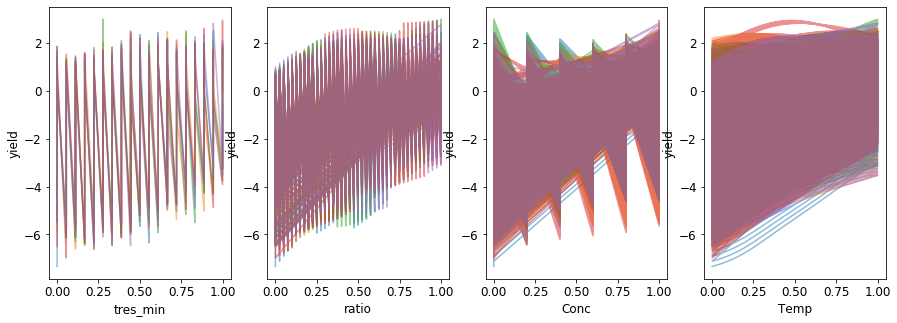

In [49]:
# Check out the samples in all dimensions

samples = bo.acq.function.samples.detach().tolist()

fig, ax = plt.subplots(1,4, figsize=(15,5))

for j in range(4):
    for i in range(5):
        ax[j].plot(domain.data.iloc[:,j].iloc[:-len(training)], samples[i][:-len(training)], alpha=0.5)
        ax[j].set_xlabel(domain.data.columns.values[j])
        ax[j].set_ylabel('yield')
    

In [11]:
# Standardized - next experiments to run

bo.proposed_experiments

,tres_min,ratio,Conc,Temp
389826,0.944444,0.400,1.0,0.811111
289470,0.666667,0.950,0.0,1.000000
133860,0.277778,1.000,0.0,1.000000
424740,1.000000,0.975,1.0,0.477778
400217,0.944444,0.875,1.0,1.000000


In [12]:
# Unstandardized - next experiments to run

domain.base_data.iloc[bo.proposed_experiments.index.values]

,tres_min,ratio,Conc,Temp
389826,2.1,2.6,0.6,133.0
289470,1.6,4.8,0.1,150.0
133860,0.9,5.0,0.1,150.0
424740,2.2,4.9,0.6,103.0
400217,2.1,4.5,0.6,150.0


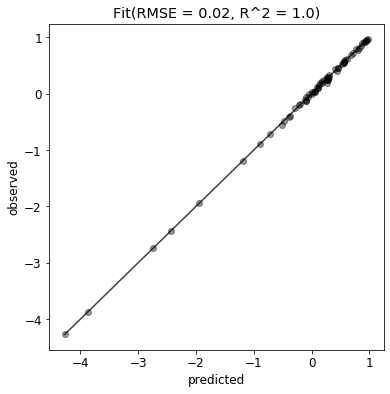

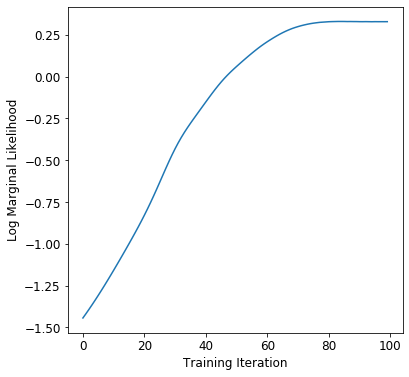

In [28]:
# See how the model fits the data

bo.model.regression()

# And the training loss

import matplotlib.pyplot as plt

loss = [-1 * x for x in bo.model.fit_restart_loss[0]]
plt.plot(range(len(loss)), loss)
plt.xlabel('Training Iteration')
plt.ylabel('Log Marginal Likelihood')
plt.show()

In [29]:
# And what the most important paramters are (remmber smaller length scale implies greater variation)

ls = bo.model.model.covar_module.base_kernel.lengthscale.detach().tolist()
pd.DataFrame(ls, columns=domain.data.columns.values)

,tres_min,ratio,Conc,Temp
0,1.437338,1.217715,1.67524,1.5532


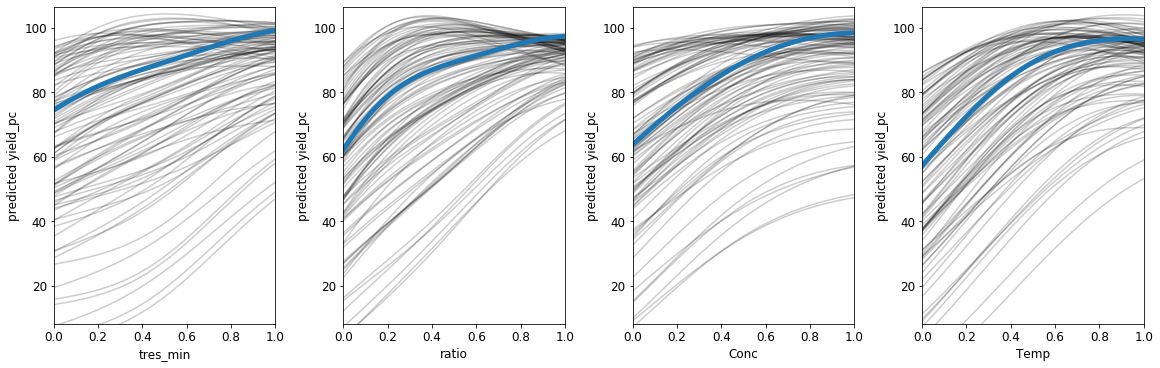

In [30]:
# Everything looks pretty much the same
# We can see this in the 1D projections

from plot_utils import dependence_plot

dependence_plot(bo, domain.data.columns.values, samples=100, export_path=None)

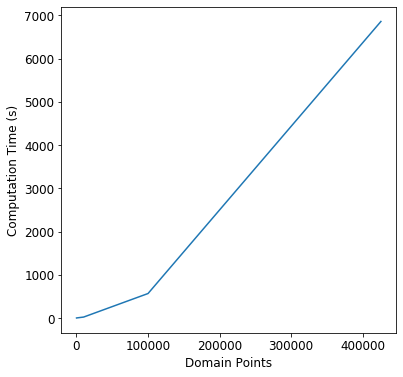

In [31]:
plt.plot([100, 1000, 10000, 100000, len(domain.data)], [1.4, 3.9, 22.5, 566.8, 6856.6])
plt.xlabel('Domain Points')
plt.ylabel('Computation Time (s)')
plt.show()

Not too bad. It looks like the time complexity is linear in the number of domain points until 100,000 poitns. I suspect I can improve on this a little bit more with some additional optimization. However, there is a fundamental limit based on computational complexity. The same goes for EI where the acquisition computations are even more costly than TS.

I think BO will be most beneficial when the space is not too big - say < 100,000 points. It is critical to put as much knowledge as you can into pruning the search space such that it doesn't contain redundant conditions. For example, here temperature is on a 1 degree grid but it is unlikely that 61 C would give very different results than 62 C. I think this tool will be best used in rounds. For example, you could run an initial round of BO with a 5 or 10 degree grid. Then afterwards further refine the conditions over a smaller range with a second round of BO on a 1 degree grid. The computation time for TS goes from ~ 2 h for the 1 degree grid to ~ 10 min with a 5 degree grid.
